In [6]:
# Functions
print('start...')
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
import keras
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import optimizers
# For some reason I have to tell it to use TensorFlows dimension ordering
from keras import backend as K
K.set_image_dim_ordering('tf')
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from time import time
import os
import tensorflow as tf
from keras import applications
from keras.utils import multi_gpu_model
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from scipy.ndimage import rotate

from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.visible_device_list = "3"
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

# Globals
# Class 0 = backgrounds
# Server scratch
# Prem..
# CLASSDIR_0 = '/vol/vssp/cvpwrkspc01/scratch/wm0015/download/prem/Segments/'#P_Tomo_6CMBCF_XYZ_5*'
# CLASSDIR_1 = '/vol/vssp/cvpwrkspc01/scratch/wm0015/download/prem/2D/6mm/'#P_6CMBCF*'
# CLASSDIR_0 = '/vol/vssp/cvpwrkspc01/scratch/wm0015/download/prem/Segments/'#P_Tomo_6CMBCF_XYZ_5*'
# CLASSDIR_1 = '/vol/vssp/cvpwrkspc01/scratch/wm0015/download/prem/2D/my/6mm_c95'#P_6CMBCF*

# CLASSDIR_0 = '/vol/vssp/cvpwrkspc01/scratch/wm0015/download2/4AFC-study-data/BgTomoFiltered_visualcheck_6mm'
# CLASSDIR_1 = '/vol/vssp/cvpwrkspc01/scratch/wm0015/download2/4AFC-study-data/Final_dataset/2D/6mm'
# CLASSDIR_0 = '/vol/vssp/cvpwrkspc01/scratch/wm0015/crops256/malignant/1.2.840.113619.2.227.2079*'
# CLASSDIR_1 = '/vol/vssp/cvpwrkspc01/scratch/wm0015/crops256/malignant/1.2.840.113619.2.227.2079*'
# CLASSDIR_0 = '/vol/vssp/cvpwrkspc01/scratch/wm0015/crops256/normal/*'
# CLASSDIR_1 = '/vol/vssp/cvpwrkspc01/scratch/wm0015/crops256/malignant/*'

# Calcs
# CLASSDIR_0 = '/user/HS204/wm0015/student/allCalcs/0/*'
# CLASSDIR_1 = '/user/HS204/wm0015/student/allCalcs/1/*'


class TrainValTensorBoard(TensorBoard):
    def __init__(self, log_dir=LOGGING_DIR, **kwargs):
        # Make the original `TensorBoard` log to a subdirectory 'training'
        fCount=0
        while os.path.exists(os.path.join(log_dir, 'training' + '_' + str(fCount))):
            fCount+=1
        training_log_dir = os.path.join(log_dir, 'training' + '_' + str(fCount))
        super(TrainValTensorBoard, self).__init__(training_log_dir, **kwargs)

        # Log the validation metrics to a separate subdirectory
        self.val_log_dir = os.path.join(log_dir, 'validation' + '_' + str(fCount))

    def set_model(self, model):
        # Setup writer for validation metrics
        self.val_writer = tf.summary.FileWriter(self.val_log_dir)
        super(TrainValTensorBoard, self).set_model(model)

    def on_epoch_end(self, epoch, logs=None):
        # Pop the validation logs and handle them separately with
        # `self.val_writer`. Also rename the keys so that they can
        # be plotted on the same figure with the training metrics
        logs = logs or {}
        val_logs = {k.replace('val_', ''): v for k, v in logs.items() if k.startswith('val_')}
        for name, value in val_logs.items():
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.val_writer.add_summary(summary, epoch)
        self.val_writer.flush()

        # Pass the remaining logs to `TensorBoard.on_epoch_end`
        logs = {k: v for k, v in logs.items() if not k.startswith('val_')}
        super(TrainValTensorBoard, self).on_epoch_end(epoch, logs)

    def on_train_end(self, logs=None):
        super(TrainValTensorBoard, self).on_train_end(logs)
        self.val_writer.close()

    
        
def getSensitivityCallback(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())
def getSpecificityCallback(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())        

def getBitDepth(img):
    print('Bit depth: img.shape: ', img.shape)
    print('img.shape: ', img.shape)
    maxmax = 0
    count = 0
    for _ in img:
        count += 1
        print(np.amax(_), ' ', count)
        if np.amax(_) > maxmax:
            maxmax = np.amax(_)
    return maxmax

def get_labels_one_hot(num_classes, class_id, num_samples):
    x = np.zeros((num_samples, num_classes))
    x[np.arange(num_samples),class_id] = 1
    return x

def fourCNN():
    model = Sequential()
    # Layer 1
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=INPUT_SHAPE, data_format='channels_last'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer 2
    model.add(Conv2D(32, (3,3), activation='relu')) 
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer 3    
    model.add(Conv2D(32, (3,3), activation='relu'))  
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer 4     
    model.add(Conv2D(32, (3,3), activation='relu'))   
    model.add(MaxPooling2D(pool_size=(2, 2)))    
    # Layer 5     
    #model.add(Conv2D(32, (3,3), activation='relu'))   
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer 6
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    return model
    
def fiveCNN():
    model = Sequential()
    # Layer 1
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=INPUT_SHAPE, data_format='channels_last'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer 2
    model.add(Conv2D(32, (3,3), activation='relu')) 
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer 3    
    model.add(Conv2D(32, (3,3), activation='relu'))  
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer 4     
    model.add(Conv2D(32, (3,3), activation='relu'))   
    model.add(MaxPooling2D(pool_size=(2, 2)))    
    # Layer 5     
    model.add(Conv2D(32, (3,3), activation='relu'))   
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer 6
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))  
    return model
    
def bigCNN():
    model = Sequential()
    # Layer 1
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=INPUT_SHAPE, data_format='channels_last'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer 2
    model.add(Conv2D(64, (3,3), activation='relu')) 
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer 3    
    model.add(Conv2D(124, (3,3), activation='relu'))  
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer 4     
    model.add(Conv2D(256, (3,3), activation='relu'))   
    model.add(MaxPooling2D(pool_size=(2, 2)))    
    # Layer 5     
    model.add(Conv2D(512, (3,3), activation='relu'))   
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer 6
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))  
    return model

def vgg():
    vggModel = applications.VGG19(weights = 'imagenet', include_top=False, input_shape = INPUT_SHAPE)
    # Add custom final layer
    model = vggModel.output
    model = Flatten()(model)
    model = Dense(2, activation='softmax')(model)
    model = keras.models.Model(inputs=vggModel.input, outputs=model)
    return model

# A function that given an image, returns n amount of augmentations (rotations)
def multiRotate(img):
    angle = np.random.randint(0, 360)
    return rotate(img, angle, axes=(0,1), reshape=False)

def augmentRotate(img, n):
    from multiprocessing.dummy import Pool as ThreadPool
    pool = ThreadPool(16)
    print('augmentRotate - img.shape', img.shape)
    aug = []
    for i in range(n):
        results = pool.map(multiRotate, img)
        #angle = np.random.randint(0, 360)
        #aug.append(rotate(img, angle, axes=(1,2), reshape=False))
    aug = np.asarray([results[_] for _ in range(len(results))])
    print('aug.shape: ', aug.shape)
    aug = np.ndarray.flatten(aug).reshape(-1, aug.shape[1], aug.shape[2], aug.shape[3])
    return aug

def tlVGG(train_data, val_data, test_data):
    #Augment the images (rotate)
    print('Augment...')
    num_augmentations = 5
    train_data['img'] = augmentRotate(train_data['img'], num_augmentations)
    val_data['img'] = augmentRotate(val_data['img'], num_augmentations)
    test_data['img'] = augmentRotate(test_data['img'], num_augmentations)    
    
    print('Compute bottleneck features...')
    vggModel = applications.VGG19(weights = "imagenet", include_top=False, input_shape = INPUT_SHAPE)
    # Freeze all layers
    for layer in vggModel.layers:
        layer.trainable = False
    # Add custom final layer
    bNModel = vggModel.output
    bNModel = Flatten()(bNModel)
    final_model = keras.models.Model(inputs=vggModel.input, outputs=bNModel)
    train_bNFeatures = {'img': 0, 'label': train_data['label']}
    val_bNFeatures = {'img': 0, 'label': val_data['label']}
    test_bNFeatures = {'img': 0, 'label': test_data['label'], 'fileName': list(test_data['fileName'])}
    train_bNFeatures['img'] = final_model.predict(train_data['img'], batch_size=16)
    val_bNFeatures['img'] = final_model.predict(val_data['img'], batch_size=16)
    test_bNFeatures['img'] = final_model.predict(test_data['img'], batch_size=16)
    #Undo one hot - ROC does not work with onehot
    val_bNFeatures.update({'labelIndex': np.where(val_data['label']==1)[1]})
    test_bNFeatures.update({'labelIndex': np.where(test_data['label']==1)[1]})


    print('train_bNFeatures[img].shape = ', train_bNFeatures['img'].shape)
    print('val_bNFeatures[img].shape = ', val_bNFeatures['img'].shape)
    print('test_bNFeatures[img].shape = ', test_bNFeatures['img'].shape)

    print('Train head...')
    head = Sequential()
    #head.add(Dense(32, input_dim=train_bNFeatures['img'].shape[1], activation='relu'))
    head.add(Dense(2, activation='softmax'))    
    return head, train_bNFeatures, val_bNFeatures, test_bNFeatures

    # Why oh why are they in a directory structure like this
def getPremFiles(imgPath, dataSpecs):
    import pydicom
    from fnmatch import fnmatch
    # First get all the 6mm lesions
    fileList = []
    for path, subdirs, files in os.walk(imgPath):
        for name in files:
            if fnmatch(name, '2D_dim2d.dcm'):
                fileList.append(os.path.join(path, name))
    # I can't remember why I thought dataSpecs was a good idea
    # I suppose this means that class 0 needs to be loaded in first
    dataSpecs['classLength'].append(len(fileList))
    
    # Load the files from filelist into an array
    print(len(fileList), ' Files found')
    print('Loading images...')
    dicomImg = np.asarray([])
    count = 0
    for f in fileList:
        dicomImg = np.append(dicomImg, pydicom.dcmread(f).pixel_array)
        count += 1
        print(count, '/', len(fileList))
    return dicomImg

def getFileName(filepath, levels=1):
    common = filepath
    for i in range(levels + 1):
        common = os.path.dirname(common)
    return os.path.relpath(filepath, common)


def getDicomImages(data, paths, strMatch = '*.dcm', verbose = True):  
    print('Getting dicom images')
    import pydicom
    from fnmatch import fnmatch
    # Get file paths of images
    tmp = [[],[]]
    tmpName = [[],[]]
    for index, p in enumerate(paths):
        fileList = []
        print(p)
        for path, subdirs, files in os.walk(p):
            for name in files:
                if fnmatch(name, strMatch): # '2D_dim2d.dcm'
                    fileList.append(os.path.join(path, name))
                    tmpName[index].append(getFileName(os.path.dirname(os.path.dirname(fileList[-1])), 0))
                    #print(tmpName[index][-1])
        data['classLength'].append(len(fileList))
        if len(fileList) == 0:
            print('MY_ERROR: NO FILES FOUND')
        # Load the files from filelist into an array
        print(len(fileList), ' Files found')
        print('Loading images...')
        data['img'] = np.asarray([])
        count = 0
        for f in fileList:
            tmp[index] = np.append(tmp[index], pydicom.dcmread(f).pixel_array)
            count += 1
            if verbose == True:
                print(count, '/', len(fileList))
        
    # Reshape the images
    tmp[0] = tmp[0].reshape((-1, INPUT_SHAPE[0], INPUT_SHAPE[1], 1))
    tmp[0] = tmp[0][0:data['classLength'][1],:,:,:] # Balance the dataset
    tmpName[0] = tmpName[0][0:data['classLength'][1]] # Balance the dataset
    tmp[1] = tmp[1].reshape((-1, INPUT_SHAPE[0], INPUT_SHAPE[1], 1))
    
    # Update class length
    data['classLength'][0] = tmp[0].shape[0]
    data['classLength'][1] = tmp[1].shape[0]
    
    # Concatenate the classes
    print('tmp[0].shape: ', tmp[0].shape)
    print('tmp[1].shape: ', tmp[1].shape)
    data['img'] = np.concatenate((tmp[0],tmp[1]))
    data['fileName'] = np.concatenate((tmpName[0], tmpName[1]))
    # Add the channels
    print('data[Img].shape = ', data['img'].shape)
    data['img'] = np.concatenate((data['img'], data['img'], data['img']), axis = 3)
    print('data[Img].shape = ', data['img'].shape)
    return data

# For non dicom images
def getImages(data, paths):    
    print('Getting non-dicom images')
    tmp = [[],[]]
    for index, p in enumerate(paths):
        fileList = glob.glob(p) #'BengaliBMPConvert/*.bmp' 
        data['classLength'].append(len(fileList))
        tmp[index] = np.array([(cv2.imread(fname)) for fname in fileList])
    print('tmp[0].shape: ', tmp[0].shape)
    print('tmp[1].shape: ', tmp[1].shape)
    data['img'] = np.concatenate((tmp[0], tmp[1]))
    return data

def getImagesOld(path, dataSpecs):
    fileList = glob.glob(path) #'BengaliBMPConvert/*.bmp'   
    num = len(fileList)
    dataSpecs['classLength'].append(len(fileList))
    x = np.array([(cv2.imread(fname)) for fname in fileList])
    return x

    # Comment out for prem images
#     data['img'] = np.concatenate((
#             get_images(CLASSDIR_0, dataSpecs), # Class 0 (backgrounds)
#             get_images(CLASSDIR_1, dataSpecs) # Class 1 
#     ))         


def colourDrop3to1(data):   
    data['img'] = data['img'][:,:,:,0]
    data['img'] = np.reshape(data['img'], (data['img'].shape[0],data['img'].shape[1],data['img'].shape[2],1))
    print('new data shape = ', data['img'].shape)
    return data

def getSensitivity(y_true, y_score):
    y_score = np.rint(y_score)
    tn, fp, fn, tp = confusion_matrix(y_true, y_score, labels=[0,1]).ravel()
#     print('Sensitivity:\ny_true:\n', y_true, '\ny_score:\n', y_score)
#     print(' tn: ', tn, ' fp: ', fp, ' fn: ', fn, ' tp: ', tp)
    return tp/(tp+fn)
def getSpecificity(y_true, y_score):
    y_score = np.rint(y_score)
    tn, fp, fn, tp = confusion_matrix(y_true, y_score, labels=[0,1]).ravel()
#     print('Specificity:\ny_true:\n', y_true, '\ny_score:\n', y_score)
#     print(' tn: ', tn, ' fp: ', fp, ' fn: ', fn, ' tp: ', tp)
    return tn/(tn+fp)

# The split is based on the fold number so that, with enough folds, every
# image will have been used in the test set
def splitDataset4AFC(data, fold, includeTestSet = True):
    print('data[img].shape', data['img'].shape)
    if includeTestSet == True:       
        splitRatio = TRAIN_RATIO    
        numImages = data['img'].shape[0]
        numTestImages = int(numImages * ((1-splitRatio)/2))
        splitPointTest = int((fold + 1) * (numImages * ((1-splitRatio)/2)))
        testMask = np.asarray(range(numTestImages)) + fold * numTestImages
        test_data = {'img': data['img'][splitPointTest - numTestImages: splitPointTest], 
                     'label': data['label'][splitPointTest - numTestImages:splitPointTest], 
                     'fileName': data['fileName'][splitPointTest - numTestImages:splitPointTest]}
        # Create shuffle mask out of remaining indexes
        shuffleMask = np.arange(numImages)
        # Remove test indexes from shuffleMask
        tmpTestMask = np.full((numImages), True)
        tmpTestMask[testMask] = False
        shuffleMask = shuffleMask[tmpTestMask]
        # Set val and train data
        np.random.shuffle(shuffleMask)
        tmpdata = dict(data)
        tmpdata['img'] = data['img'][shuffleMask]
        tmpdata['label'] = data['label'][shuffleMask]
        tmpdata['fileName'] = data['fileName'][shuffleMask]
        splitPointVal = numTestImages
        val_data = {'img': tmpdata['img'][0:splitPointVal], 'label': tmpdata['label'][0:splitPointVal]}
        train_data = {'img': tmpdata['img'][splitPointVal:], 'label': tmpdata['label'][splitPointVal:]}


        print('splitPointVal: ', splitPointVal)
        print('splitPointTest: ', splitPointTest)
                                
        print('val_data[img].shape: ', val_data['img'].shape)
        print('test_data[img].shape: ', test_data['img'].shape)
        print('train_data[img].shape', train_data['img'].shape)
        print('val_data[label].shape: ', val_data['label'].shape)
        print('test_data[label].shape: ', test_data['label'].shape)        
        print('train_data[label].shape: ', train_data['label'].shape)
        #Undo one hot - ROC does not work with onehot
        val_data.update({'labelIndex': np.where(val_data['label']==1)[1]})
        test_data.update({'labelIndex': np.where(test_data['label']==1)[1]})
        return train_data, val_data, test_data        

def splitDataset(data, seed = None, includeTestSet = True):
    if includeTestSet == True:
        # Shuffle data
        if seed != None:
            np.random.seed(seed) # Has to be set before each use of random
        shuffleMask = np.random.permutation(data['img'].shape[0]) 
        tmpdata = dict(data)
        tmpdata['img'] = data['img'][shuffleMask, :, :, :]
        tmpdata['label'] = data['label'][shuffleMask, :]
        # Split traing and validation data        
        splitRatio = TRAIN_RATIO
        splitPointVal = math.floor(tmpdata['img'].shape[0]*(1-splitRatio)/2)
        splitPointTest = math.floor(tmpdata['img'].shape[0]*(1-splitRatio))
        val_data = {'img': tmpdata['img'][0:splitPointVal], 
                    'label': tmpdata['label'][0:splitPointVal]}
        test_data = {'img': tmpdata['img'][splitPointVal:splitPointTest], 
                     'label': tmpdata['label'][splitPointVal:splitPointTest],
                     'fileName': tmpdata['fileName'][splitPointVal:splitPointTest]}
        train_data = {'img': tmpdata['img'][splitPointTest:], 
                      'label': tmpdata['label'][splitPointTest:]}

        print('val_data[img].shape: ', val_data['img'].shape)
        print('test_data[img].shape: ', test_data['img'].shape)
        print('train_data[img].shape', train_data['img'].shape)
        print('val_data[label].shape: ', val_data['label'].shape)
        print('test_data[label].shape: ', test_data['label'].shape)        
        print('train_data[label].shape: ', train_data['label'].shape)
        #Undo one hot - ROC does not work with onehot
        val_data.update({'labelIndex': np.where(val_data['label']==1)[1]})
        test_data.update({'labelIndex': np.where(test_data['label']==1)[1]})
        return train_data, val_data, test_data
    else:
        # Shuffle data
        if setSeed != None:
            np.random.seed(seed) # Has to be set before each use of random
        shuffleMask = np.random.permutation(data['img'].shape[0]) 
        tmpdata['img'] = data['img'][shuffleMask, :, :, :]
        tmpdata['label'] = data['label'][shuffleMask, :]
        # Split traing and validation data        
        splitRatio = TRAIN_RATIO
        splitPoint = math.floor(tmpdata['img'].shape[0]*splitRatio)
        train_data = {'img': tmpdata['img'][0:splitPoint], 'label': tmpdata['label'][0:splitPoint]}
        val_data = {'img': tmpdata['img'][splitPoint:], 'label': tmpdata['label'][splitPoint:]}
        print('TrainLabels.shape: ', train_data['label'].shape)
        print('val_data.shape: ', val_data['label'].shape)
        #Undo one hot - ROC does not work with onehot
        val_data.update({'labelIndex': np.where(val_data['label']==1)[1]})
        return train_data, val_data
print('Done')

start...
Done


In [9]:
# Globals
CLASSDIR_0 = '/vol/research/mammo2/will/data/old/oldNetworkScratch/wm0015/download/prem/Segments/'
CLASSDIR_1 = '/vol/research/mammo2/will/data/old/oldNetworkScratch/wm0015/download/prem/2D/4mm/'
#CLASSDIR_1 = '/vol/research/mammo2/will/data/old/oldNetworkScratch/wm0015/download/prem/2D/6mm/'
VERBOSE = 0
ARCHITECTURE = 0
NORMALISE = 4096
MODEL_SAVE = '/vol/research/mammo2/will/data/models/best_model.h5'
LOGGING_DIR = '/vol/research/mammo2/will/logs/new'
BATCH_SIZE = 100
EPOCHS = 100
TRAIN_RATIO = 1-(118/1062)*2
INPUT_SHAPE = [429, 429, 3]
#INPUT_SHAPE = [256, 256, 3]
#INPUT_SHAPE = [385, 385, 3]
FOLDS = 10
PATIENCE = 1000

In [5]:
# Get data
globalData = {'img': 0, 'label': 0, 'fileName': [], 'classLength':[]}
globalData = getDicomImages(globalData, (CLASSDIR_0, CLASSDIR_1), strMatch = '2D_dim2d.dcm', verbose = False)
# globaData = getDicomImages(data, (CLASSDIR_0, CLASSDIR_1))
# globalData = getDicomImages(data, (CLASSDIR_0, CLASSDIR_1))
print('Done')

Getting dicom images
/vol/research/mammo2/will/data/old/oldNetworkScratch/wm0015/download/prem/Segments/
1176  Files found
Loading images...
/vol/research/mammo2/will/data/old/oldNetworkScratch/wm0015/download/prem/2D/4mm/
554  Files found
Loading images...
tmp[0].shape:  (554, 429, 429, 1)
tmp[1].shape:  (554, 429, 429, 1)
data[Img].shape =  (1108, 429, 429, 1)
data[Img].shape =  (1108, 429, 429, 3)
Done


keras version:  2.2.0
TensorFlow version:  1.7.1

Loading images...
labels0.shape:  (554, 2)
labels1.shape:  (554, 2)
data[label].shape:  (1108, 2)
data[img].dtype:  float64
data[img].dtype:  float64
val_data[img].shape:  (123, 429, 429, 3)
test_data[img].shape:  (123, 429, 429, 3)
train_data[img].shape (862, 429, 429, 3)
val_data[label].shape:  (123, 2)
test_data[label].shape:  (123, 2)
train_data[label].shape:  (862, 2)
Augment...
augmentRotate - img.shape (862, 429, 429, 3)
aug.shape:  (862, 429, 429, 3)
augmentRotate - img.shape (123, 429, 429, 3)
aug.shape:  (123, 429, 429, 3)
augmentRotate - img.shape (123, 429, 429, 3)
aug.shape:  (123, 429, 429, 3)
Compute bottleneck features...
train_bNFeatures[img].shape =  (862, 86528)
val_bNFeatures[img].shape =  (123, 86528)
test_bNFeatures[img].shape =  (123, 86528)
Train head...
Train...
             Model converged:  74.79674777364343 %


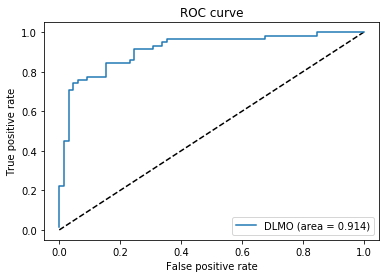

The score is......
 [0.4047105552219763, 0.8455284518924185]
Sensitivity:  0.7413793103448276
Specificity:  0.9384615384615385
val_data[img].shape:  (123, 429, 429, 3)
test_data[img].shape:  (123, 429, 429, 3)
train_data[img].shape (862, 429, 429, 3)
val_data[label].shape:  (123, 2)
test_data[label].shape:  (123, 2)
train_data[label].shape:  (862, 2)
Augment...
augmentRotate - img.shape (862, 429, 429, 3)
aug.shape:  (862, 429, 429, 3)
augmentRotate - img.shape (123, 429, 429, 3)
aug.shape:  (123, 429, 429, 3)
augmentRotate - img.shape (123, 429, 429, 3)
aug.shape:  (123, 429, 429, 3)
Compute bottleneck features...
train_bNFeatures[img].shape =  (862, 86528)
val_bNFeatures[img].shape =  (123, 86528)
test_bNFeatures[img].shape =  (123, 86528)
Train head...
Train...
             Model DID NOT converge:  52.032520397891844 %
val_data[img].shape:  (123, 429, 429, 3)
test_data[img].shape:  (123, 429, 429, 3)
train_data[img].shape (862, 429, 429, 3)
val_data[label].shape:  (123, 2)
test_data

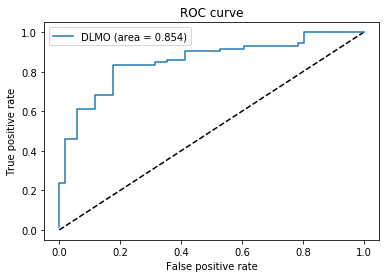

The score is......
 [0.5278286362082009, 0.7967479737793527]
Sensitivity:  0.7777777777777778
Specificity:  0.8235294117647058
val_data[img].shape:  (123, 429, 429, 3)
test_data[img].shape:  (123, 429, 429, 3)
train_data[img].shape (862, 429, 429, 3)
val_data[label].shape:  (123, 2)
test_data[label].shape:  (123, 2)
train_data[label].shape:  (862, 2)
Augment...
augmentRotate - img.shape (862, 429, 429, 3)
aug.shape:  (862, 429, 429, 3)
augmentRotate - img.shape (123, 429, 429, 3)
aug.shape:  (123, 429, 429, 3)
augmentRotate - img.shape (123, 429, 429, 3)
aug.shape:  (123, 429, 429, 3)
Compute bottleneck features...
train_bNFeatures[img].shape =  (862, 86528)
val_bNFeatures[img].shape =  (123, 86528)
test_bNFeatures[img].shape =  (123, 86528)
Train head...
Train...
             Model converged:  82.11382079899796 %


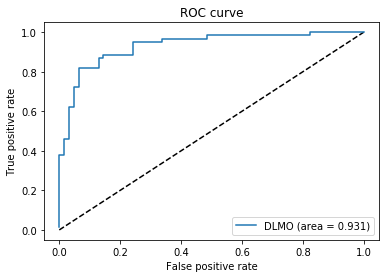

The score is......
 [0.34447711366948075, 0.8699187054866697]
Sensitivity:  0.8852459016393442
Specificity:  0.8548387096774194
val_data[img].shape:  (123, 429, 429, 3)
test_data[img].shape:  (123, 429, 429, 3)
train_data[img].shape (862, 429, 429, 3)
val_data[label].shape:  (123, 2)
test_data[label].shape:  (123, 2)
train_data[label].shape:  (862, 2)
Augment...
augmentRotate - img.shape (862, 429, 429, 3)
aug.shape:  (862, 429, 429, 3)
augmentRotate - img.shape (123, 429, 429, 3)
aug.shape:  (123, 429, 429, 3)
augmentRotate - img.shape (123, 429, 429, 3)
aug.shape:  (123, 429, 429, 3)
Compute bottleneck features...
train_bNFeatures[img].shape =  (862, 86528)
val_bNFeatures[img].shape =  (123, 86528)
test_bNFeatures[img].shape =  (123, 86528)
Train head...
Train...
             Model converged:  78.86178924785396 %


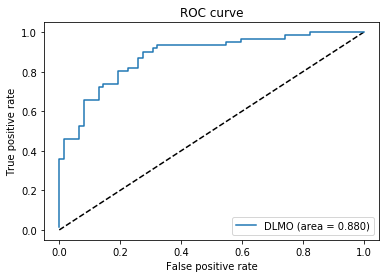

The score is......
 [0.46959576907196665, 0.7804877995475521]
Sensitivity:  0.7377049180327869
Specificity:  0.8225806451612904
val_data[img].shape:  (123, 429, 429, 3)
test_data[img].shape:  (123, 429, 429, 3)
train_data[img].shape (862, 429, 429, 3)
val_data[label].shape:  (123, 2)
test_data[label].shape:  (123, 2)
train_data[label].shape:  (862, 2)
Augment...
augmentRotate - img.shape (862, 429, 429, 3)
aug.shape:  (862, 429, 429, 3)
augmentRotate - img.shape (123, 429, 429, 3)
aug.shape:  (123, 429, 429, 3)
augmentRotate - img.shape (123, 429, 429, 3)
aug.shape:  (123, 429, 429, 3)
Compute bottleneck features...
train_bNFeatures[img].shape =  (862, 86528)
val_bNFeatures[img].shape =  (123, 86528)
test_bNFeatures[img].shape =  (123, 86528)
Train head...
Train...
             Model converged:  76.42276417918322 %


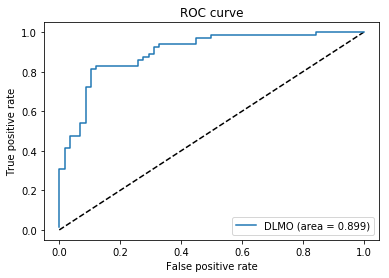

The score is......
 [0.4417162542420674, 0.8373983754375116]
Sensitivity:  0.7846153846153846
Specificity:  0.896551724137931
val_data[img].shape:  (123, 429, 429, 3)
test_data[img].shape:  (123, 429, 429, 3)
train_data[img].shape (862, 429, 429, 3)
val_data[label].shape:  (123, 2)
test_data[label].shape:  (123, 2)
train_data[label].shape:  (862, 2)
Augment...
augmentRotate - img.shape (862, 429, 429, 3)
aug.shape:  (862, 429, 429, 3)
augmentRotate - img.shape (123, 429, 429, 3)
aug.shape:  (123, 429, 429, 3)
augmentRotate - img.shape (123, 429, 429, 3)
aug.shape:  (123, 429, 429, 3)
Compute bottleneck features...
train_bNFeatures[img].shape =  (862, 86528)
val_bNFeatures[img].shape =  (123, 86528)
test_bNFeatures[img].shape =  (123, 86528)
Train head...
Train...
             Model converged:  82.92682907445645 %


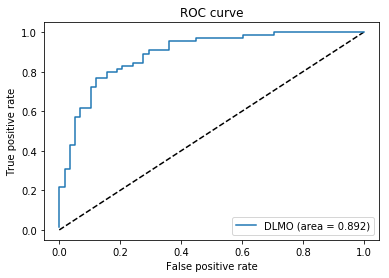

The score is......
 [0.44830448501478365, 0.8048780531418033]
Sensitivity:  0.8
Specificity:  0.8103448275862069
val_data[img].shape:  (123, 429, 429, 3)
test_data[img].shape:  (123, 429, 429, 3)
train_data[img].shape (862, 429, 429, 3)
val_data[label].shape:  (123, 2)
test_data[label].shape:  (123, 2)
train_data[label].shape:  (862, 2)
Augment...
augmentRotate - img.shape (862, 429, 429, 3)
aug.shape:  (862, 429, 429, 3)
augmentRotate - img.shape (123, 429, 429, 3)
aug.shape:  (123, 429, 429, 3)
augmentRotate - img.shape (123, 429, 429, 3)
aug.shape:  (123, 429, 429, 3)
Compute bottleneck features...
train_bNFeatures[img].shape =  (862, 86528)
val_bNFeatures[img].shape =  (123, 86528)
test_bNFeatures[img].shape =  (123, 86528)
Train head...
Train...
             Model converged:  82.92682892907925 %


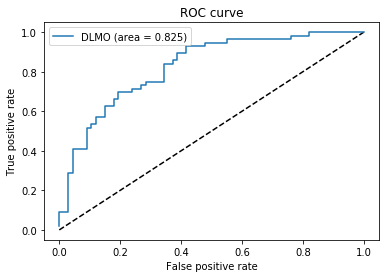

The score is......
 [0.5981321548058735, 0.7398373978893932]
Sensitivity:  0.6607142857142857
Specificity:  0.8059701492537313
val_data[img].shape:  (123, 429, 429, 3)
test_data[img].shape:  (123, 429, 429, 3)
train_data[img].shape (862, 429, 429, 3)
val_data[label].shape:  (123, 2)
test_data[label].shape:  (123, 2)
train_data[label].shape:  (862, 2)
Augment...
augmentRotate - img.shape (862, 429, 429, 3)
aug.shape:  (862, 429, 429, 3)
augmentRotate - img.shape (123, 429, 429, 3)
aug.shape:  (123, 429, 429, 3)
augmentRotate - img.shape (123, 429, 429, 3)
aug.shape:  (123, 429, 429, 3)
Compute bottleneck features...
train_bNFeatures[img].shape =  (862, 86528)
val_bNFeatures[img].shape =  (123, 86528)
test_bNFeatures[img].shape =  (123, 86528)
Train head...
Train...
             Model DID NOT converge:  50.40650413772924 %
val_data[img].shape:  (123, 429, 429, 3)
test_data[img].shape:  (123, 429, 429, 3)
train_data[img].shape (862, 429, 429, 3)
val_data[label].shape:  (123, 2)
test_data[

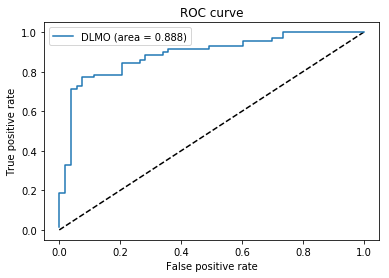

The score is......
 [0.513856886363611, 0.8292682955904704]
Sensitivity:  0.7571428571428571
Specificity:  0.9245283018867925
val_data[img].shape:  (123, 429, 429, 3)
test_data[img].shape:  (123, 429, 429, 3)
train_data[img].shape (862, 429, 429, 3)
val_data[label].shape:  (123, 2)
test_data[label].shape:  (123, 2)
train_data[label].shape:  (862, 2)
Augment...
augmentRotate - img.shape (862, 429, 429, 3)
aug.shape:  (862, 429, 429, 3)
augmentRotate - img.shape (123, 429, 429, 3)
aug.shape:  (123, 429, 429, 3)
augmentRotate - img.shape (123, 429, 429, 3)
aug.shape:  (123, 429, 429, 3)
Compute bottleneck features...
train_bNFeatures[img].shape =  (862, 86528)
val_bNFeatures[img].shape =  (123, 86528)
test_bNFeatures[img].shape =  (123, 86528)
Train head...
Train...
             Model converged:  79.67479640875406 %


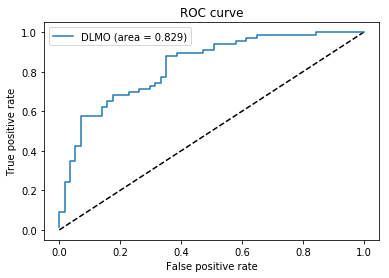

The score is......
 [0.5373070293325719, 0.756097555645113]
Sensitivity:  0.8484848484848485
Specificity:  0.6491228070175439
val_data[img].shape:  (123, 429, 429, 3)
test_data[img].shape:  (123, 429, 429, 3)
train_data[img].shape (862, 429, 429, 3)
val_data[label].shape:  (123, 2)
test_data[label].shape:  (123, 2)
train_data[label].shape:  (862, 2)
Augment...
augmentRotate - img.shape (862, 429, 429, 3)
aug.shape:  (862, 429, 429, 3)
augmentRotate - img.shape (123, 429, 429, 3)
aug.shape:  (123, 429, 429, 3)
augmentRotate - img.shape (123, 429, 429, 3)
aug.shape:  (123, 429, 429, 3)
Compute bottleneck features...
train_bNFeatures[img].shape =  (862, 86528)
val_bNFeatures[img].shape =  (123, 86528)
test_bNFeatures[img].shape =  (123, 86528)
Train head...
Train...
             Model DID NOT converge:  57.72357781728109 %
val_data[img].shape:  (123, 429, 429, 3)
test_data[img].shape:  (123, 429, 429, 3)
train_data[img].shape (862, 429, 429, 3)
val_data[label].shape:  (123, 2)
test_data[l

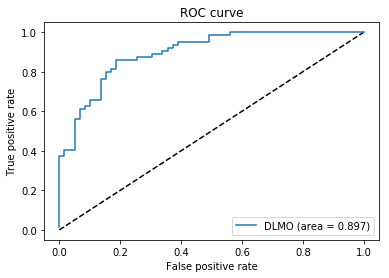

The score is......
 [0.45080477435414384, 0.7886178842404994]
Sensitivity:  0.875
Specificity:  0.6949152542372882

Validations: 
 [0.84552845 0.79674797 0.86991871 0.7804878  0.83739838 0.80487805
 0.7398374  0.8292683  0.75609756 0.78861788]
Average loss:  0.47367336582846764
Average validation:  0.8048780492650783


Sensitivities: 
 [0.7413793103448276, 0.7777777777777778, 0.8852459016393442, 0.7377049180327869, 0.7846153846153846, 0.8, 0.6607142857142857, 0.7571428571428571, 0.8484848484848485, 0.875]

Specificities: 
 [0.9384615384615385, 0.8235294117647058, 0.8548387096774194, 0.8225806451612904, 0.896551724137931, 0.8103448275862069, 0.8059701492537313, 0.9245283018867925, 0.6491228070175439, 0.6949152542372882]


Average sensitivity:  0.7868065283752113
Average specificity:  0.8220843369184448


In [10]:
def main():
    print('keras version: ', keras.__version__)
    print('TensorFlow version: ', tf.__version__)
    print('\nLoading images...')
    
    # Get images
    data = dict(globalData)

    
    # Create one hot labels
    labels0 = get_labels_one_hot(2, 0, data['classLength'][0])
    labels1 = get_labels_one_hot(2, 1, data['classLength'][1])
    print('labels0.shape: ', labels0.shape)
    print('labels1.shape: ', labels1.shape)
    data['label'] = np.concatenate((labels0, labels1))
    
    print('data[label].shape: ', data['label'].shape)
    # Get bit depth
#     print('Bit depth: ', getBitDepth(data['img']))
#     return
    # Normalise
    print('data[img].dtype: ', data['img'].dtype)
    data['img'] = data['img']/NORMALISE 
    print('data[img].dtype: ', data['img'].dtype)
    
    #data = colourDrop3to1(data)
     
    # After this things get a bit messy
    #___________________________________________________



    
    valStats = {'score':[], 'specificity':[], 'sensitivity':[]}
    exportNames = []
    exportConfidenceCancer = []
    for crossVal in range(FOLDS):
        successful = False
        while not successful:
            #train_data, val_data, test_data = splitDataset(data, seed = 9)
            train_data, val_data, test_data = splitDataset(data)
            #train_data, val_data, test_data = splitDataset4AFC(data, crossVal, includeTestSet = True)

            



            model, train_data, val_data, test_data = tlVGG(train_data, val_data, test_data)
            #model = fiveCNN()
            #model = multi_gpu_model(model, gpus=2)
            if ARCHITECTURE != 0:
                model.summary()  

            sgd = optimizers.SGD(lr=5, decay=1e-6, momentum=0.9, nesterov=True)
            adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) #0.001
            model.compile(loss='binary_crossentropy',
                        optimizer=adam,
                         metrics=['accuracy'])#, getSensitivityCallback, getSpecificityCallback])
            tensorboard = TensorBoard(log_dir='/vol/vssp/mammo2/will/logs/new'.format(time()), write_images=True)

            # Data augmentation settings
            if (1 == 2):
                from keras.preprocessing.image import ImageDataGenerator
                trainDatagen = ImageDataGenerator(
                    #featurewise_center=True,
                    #featurewise_std_normalization=True,
                    rotation_range=20,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    horizontal_flip=True)
                trainDatagen.fit(train_data['img'])
                valDatagen = ImageDataGenerator(
                    featurewise_center=True,
                    featurewise_std_normalization=True,
                    #rotation_range=20,
                    #width_shift_range=0.2,
                    #height_shift_range=0.2,
                    #horizontal_flip=True
                    )
                valDatagen.fit(val_data['img'])

    #         # Normalise myself
    #         mean_data = np.mean(train_data['img'])
    #         std_data = np.std(train_data['img'])
    #         train_data['img'] = (train_data['img']-mean_data)/std_data
    #         val_data['img'] = (val_data['img']-mean_data/std_data)

    #        # Train, with data augmentation
    #         print('Train...')
    #         model.fit_generator(trainDatagen.flow(train_data['img'], train_data['label'], batch_size=32),
    #                     steps_per_epoch=len(train_data['img']) / 32, epochs=EPOCHS, verbose=VERBOSE,
    #                            callbacks=[
    #                                TrainValTensorBoard(write_graph=False),
    #                                EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1),
    #                                ModelCheckpoint(filepath=MODEL_SAVE, monitor='val_accuracy', save_best_only=True)],
    #                            validation_data=valDatagen.flow(x = val_data['img'], y = val_data['label']))





            # Train
            print('Train...')
            model.fit(train_data['img'], train_data['label'], 
                    batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=VERBOSE,
                    callbacks=[
                        TrainValTensorBoard(write_graph=False),
                        EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1),
                        ModelCheckpoint(filepath=MODEL_SAVE, monitor='val_acc', save_best_only=True)],
                    validation_data=(val_data['img'], val_data['label']))

            # Restore best model
            #model.load_weights(MODEL_SAVE)  
            # Test for convergence (acc > 70%)
            score = model.evaluate(val_data['img'], val_data['label'], verbose=0)  
            if score[1] < 0.70:
                print('             Model DID NOT converge: ', score[1]*100, '%')
            else:
                successful = True
                print('             Model converged: ', score[1]*100, '%')

                # Produce ROC curve
                eval_data = test_data
                y_pred_keras = model.predict(eval_data['img'])  
                y_true = eval_data['labelIndex']
                y_score = y_pred_keras[:,1]
                fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true, y_score)
                from sklearn.metrics import auc
                auc_keras = auc(fpr_keras, tpr_keras)
                plt.figure(1)
                plt.plot([0, 1], [0, 1], 'k--')
                plt.plot(fpr_keras, tpr_keras, label='DLMO (area = {:.3f})'.format(auc_keras))
                plt.xlabel('False positive rate')
                plt.ylabel('True positive rate')
                plt.title('ROC curve')
                plt.legend(loc='best')
                plt.show()




                # Evaluate
                score = model.evaluate(eval_data['img'], eval_data['label'], verbose=0)
                valStats['score'].append(score)
                print('The score is......\n', score)
                valStats['sensitivity'].append(getSensitivity(y_true, y_score))
                valStats['specificity'].append(getSpecificity(y_true, y_score))
                print('Sensitivity: ', valStats['sensitivity'][-1])
                print('Specificity: ', valStats['specificity'][-1])
  

    valStatsScore = np.asarray(valStats['score'])
    print('\nValidations: \n', valStatsScore[:, 1])
    print('Average loss: ', sum(valStatsScore[:, 0])/FOLDS)
    print('Average validation: ', sum(valStatsScore[:, 1])/FOLDS)
    print('\n\nSensitivities: \n', valStats['sensitivity'])
    print('\nSpecificities: \n', valStats['specificity'])
    print('\n\nAverage sensitivity: ', sum(valStats['sensitivity'])/len(valStats['sensitivity']))
    print('Average specificity: ', sum(valStats['specificity'])/len(valStats['specificity']))
    
if __name__ == "__main__":
    main()